Evaluation on T5 Model, Running Optuna for Finding Suitable Hyperparameter

In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requi

In [ ]:
from datasets import load_dataset
dataset_dialog = load_dataset("knkarthick/dialogsum")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
print(dataset_dialog)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 12460
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 500
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'topic'],
        num_rows: 1500
    })
})


In [ ]:
dataset_dialog['train'][0]

{'id': 'train_0',
 'dialogue': "#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. Why are you here today?\n#Person2#: I found it would be a good idea to get a check-up.\n#Person1#: Yes, well, you haven't had one for 5 years. You should have one every year.\n#Person2#: I know. I figure as long as there is nothing wrong, why go see the doctor?\n#Person1#: Well, the best way to avoid serious illnesses is to find out about them early. So try to come at least once a year for your own good.\n#Person2#: Ok.\n#Person1#: Let me see here. Your eyes and ears look fine. Take a deep breath, please. Do you smoke, Mr. Smith?\n#Person2#: Yes.\n#Person1#: Smoking is the leading cause of lung cancer and heart disease, you know. You really should quit.\n#Person2#: I've tried hundreds of times, but I just can't seem to kick the habit.\n#Person1#: Well, we have classes and some medications that might help. I'll give you more information before you leave.\n#Person2#: Ok, thanks doctor.",
 'summary': "Mr. Smith'

In [ ]:
def find_duplicates(dataset, column_name):
    duplicates = dataset.filter(lambda record: dataset[column_name].count(record[column_name]) > 1)
    return duplicates

In [ ]:
'''train_duplicates = find_duplicates(dataset_dialog['train'], 'dialogue')

# Show the duplicate entries
print("Duplicates in the training set:")
print(train_duplicates)'''

'train_duplicates = find_duplicates(dataset_dialog[\'train\'], \'dialogue\')\n\n# Show the duplicate entries\nprint("Duplicates in the training set:")\nprint(train_duplicates)'

In [ ]:
test_dataset= dataset_dialog['test']

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
#loading T5 model and tokenizer
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
def generate_summary(record):
    input_text = record['dialogue']
    input_ids = tokenizer.encode("summarize: " + input_text, return_tensors="pt", max_length=512, truncation=True)
    output_ids = model.generate(input_ids, max_length=150, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return summary

test_dataset = test_dataset.map(lambda record: {"generated_summary": generate_summary(record)})

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
test_dataset

Dataset({
    features: ['id', 'dialogue', 'summary', 'topic', 'generated_summary'],
    num_rows: 1500
})

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=12d8459708922669553c2f9e403cf96e9606730fb4c894aea7b6cbe79d5dc7f4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
!pip install bert_score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('wordnet')
#evaluating metrics
def calculate_metrics(reference, hypothesis):
    metrics = {}

    #tokenizing reference and hypothesis for METEOR and BLEU
    reference_tokens= nltk.word_tokenize(reference)
    hypothesis_tokens= nltk.word_tokenize(hypothesis)
    #BLEUscore
    smooth_fn= SmoothingFunction().method1
    metrics['BLEU']= sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smooth_fn)
    #ROUGEscore
    scorer= rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    metrics['ROUGE-1'] = rouge_scores['rouge1'].fmeasure
    metrics['ROUGE-2'] = rouge_scores['rouge2'].fmeasure
    metrics['ROUGE-L'] = rouge_scores['rougeL'].fmeasure
    #METEORscore
    metrics['METEOR'] = meteor_score([reference_tokens], hypothesis_tokens)
    #for BERTScore 'bert-base-uncased' is used to avoid the roberta issue
    P, R, F1 = bert_score([hypothesis], [reference], lang='en', model_type='bert-base-uncased', verbose=False)
    metrics['BERTScore_P'] = P.mean().item()
    metrics['BERTScore_R'] = R.mean().item()
    metrics['BERTScore_F1'] = F1.mean().item()
    #cosinesimilarity
    vectorizer = TfidfVectorizer().fit_transform([reference, hypothesis])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(vectors)
    metrics['Cosine Similarity'] = cosine_sim[0, 1]
    return metrics

#applying metric calculation
test_results = test_dataset.map(lambda record: calculate_metrics(record['summary'], record['generated_summary']))
results_df = pd.DataFrame(test_results)
print(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].describe())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

              BLEU      ROUGE-1      ROUGE-2      ROUGE-L       METEOR  \
count  1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean      0.048333     0.244441     0.064930     0.190703     0.261485   
std       0.049381     0.114505     0.083343     0.097470     0.134353   
min       0.002502     0.000000     0.000000     0.000000     0.016667   
25%       0.015640     0.161535     0.000000     0.125000     0.155411   
50%       0.037104     0.232558     0.042553     0.175439     0.242324   
75%       0.057681     0.317073     0.100000     0.242424     0.343146   
max       0.490999     0.756757     0.571429     0.756757     0.858843   

       Cosine Similarity  BERTScore_P  BERTScore_R  BERTScore_F1  
count        1500.000000  1500.000000  1500.000000   1500.000000  
mean            0.174600     0.493534     0.538249      0.511705  
std             0.103509     0.077798     0.098754      0.078483  
min             0.000000     0.271515     0.290004      0.311156 

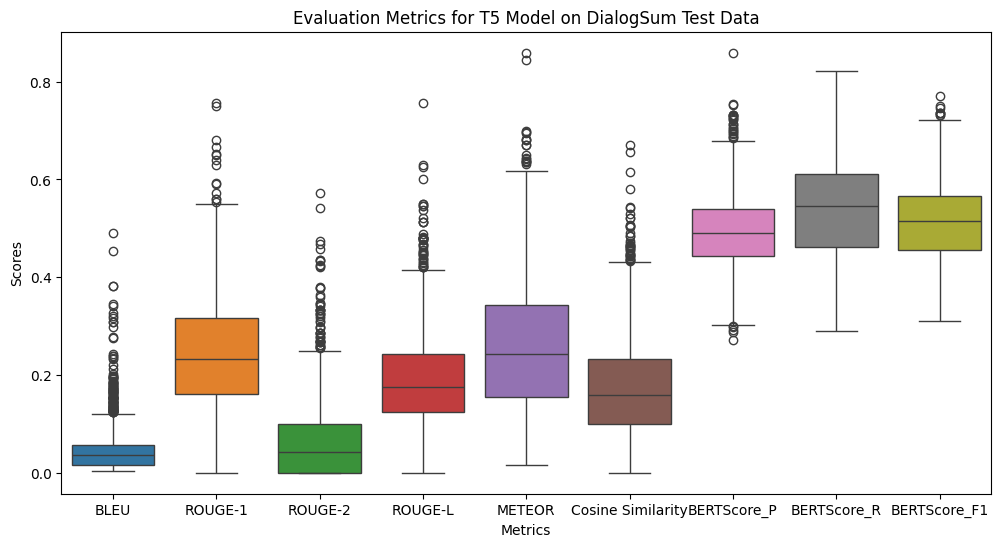

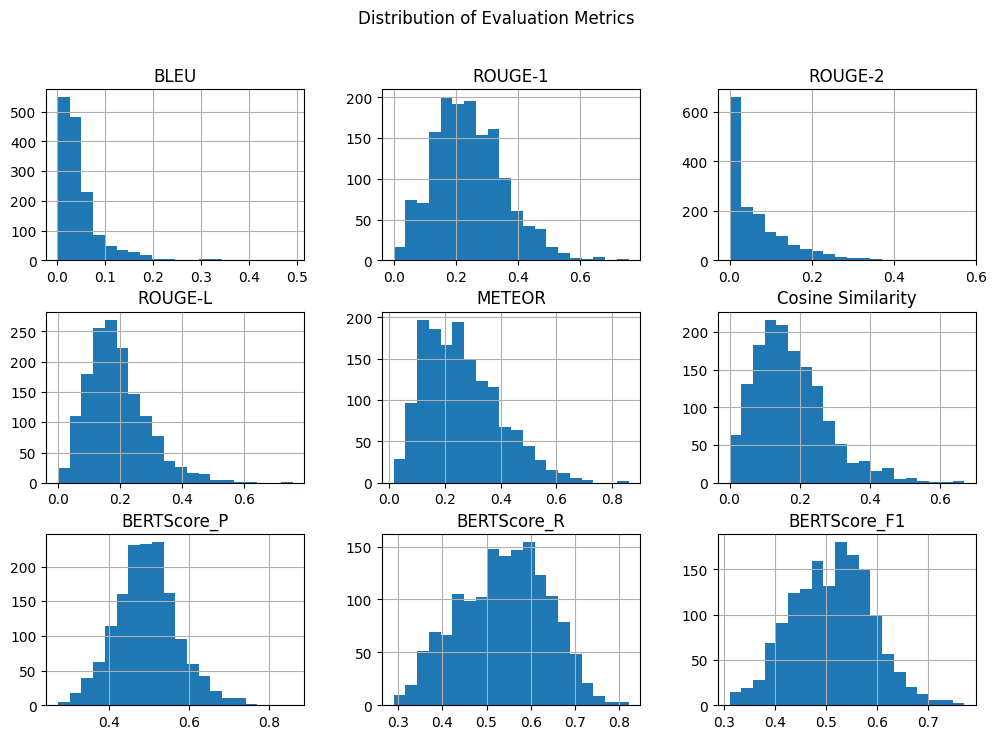

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']])
plt.title('Evaluation Metrics for T5 Model on DialogSum Test Data')
plt.ylabel('Scores')
plt.xlabel('Metrics')
plt.show()
#histogram
results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Distribution of Evaluation Metrics')
plt.show()


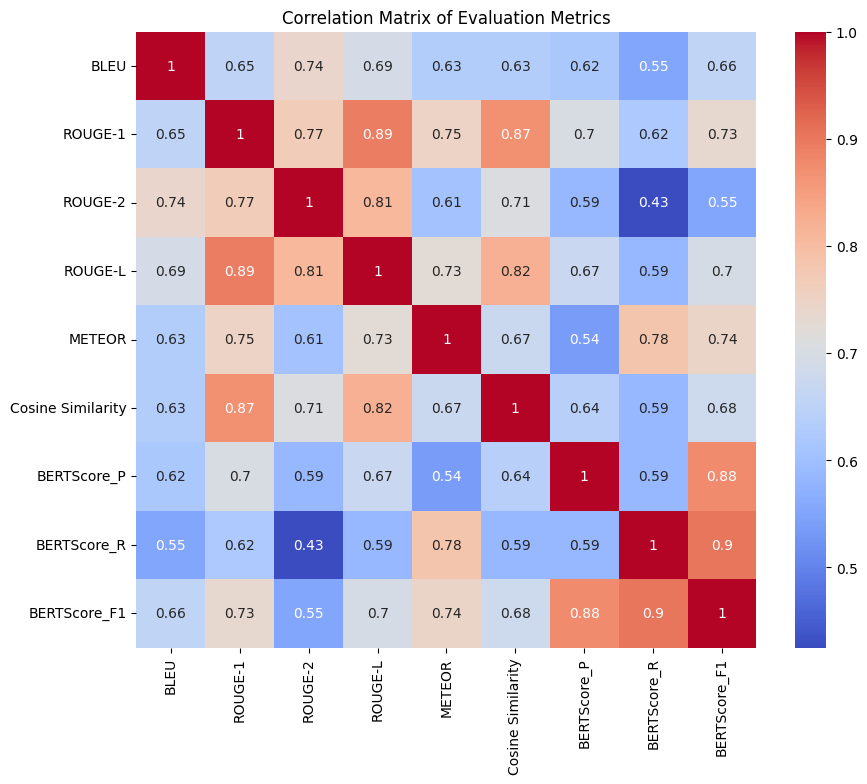

In [ ]:
#correlation-matrix
plt.figure(figsize=(10, 8))
sns.heatmap(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR','Cosine Similarity','BERTScore_P', 'BERTScore_R', 'BERTScore_F1']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Evaluation Metrics')
plt.show()

#**T5 Fine-tuning**

In [ ]:
pip install transformers datasets torch

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
#loading the DialogSum dataset using Hugging Face
dataset_ft = load_dataset("knkarthick/dialogsum")
train_dataset_ft = dataset_ft['train']
val_dataset = dataset_ft['validation']
test_dataset = dataset_ft['test']


In [ ]:
from transformers import T5Tokenizer
#tokenizer loading
tokenizer = T5Tokenizer.from_pretrained("t5-small")
#tokenizing the inputs and labels
def preprocess_function(record):
    inputs = ["summarize: " + dialogue for dialogue in record["dialogue"]]
    model_inputs= tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    labels = tokenizer(record["summary"], max_length=150, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs

#tokenization to the datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/12460 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [ ]:
'''
from transformers import Seq2SeqTrainingArguments

# Training arguments with learning rate logging
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)
'''

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import Seq2SeqTrainingArguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=9.460705253161354e-05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.005806214555009961,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

In [ ]:
#these are the best parameters suggested by Optuna (Optuna execution is belowthis training, it was used above in this code,
#for simplicity I have created a seprate file for it)
'''
{'learning_rate': 9.460705253161354e-05,
 'batch_size': 16,
 'weight_decay': 0.005806214555009961,
 'num_train_epochs': 2}
'''

In [ ]:
from transformers import T5ForConditionalGeneration, Seq2SeqTrainer
#loading the pre-trained T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-small")
#initializing the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.411200,0.351885
2,0.462500,0.338128
3,0.357000,0.335983


TrainOutput(global_step=4674, training_loss=0.427128731566818, metrics={'train_runtime': 988.75, 'train_samples_per_second': 37.805, 'train_steps_per_second': 4.727, 'total_flos': 5059076539023360.0, 'train_loss': 0.427128731566818, 'epoch': 3.0})

In [ ]:
#extracting learning rates from the logs
learning_rates = [entry['learning_rate'] for entry in trainer.state.log_history if 'learning_rate' in entry]
steps = range(len(learning_rates))
plt.figure(figsize=(10, 6))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule During Training")
plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
#evaluation metrics
def calculate_metrics(reference, hypothesis):
    metrics = {}
    #tokenizing references and hypothesis for METEOR and BLEU
    reference_tokens = nltk.word_tokenize(reference)
    hypothesis_tokens = nltk.word_tokenize(hypothesis)
    # BLEUscore
    smooth_fn = SmoothingFunction().method1
    metrics['BLEU'] = sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smooth_fn)
    # ROUGEscore
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(reference, hypothesis)
    metrics['ROUGE-1'] = rouge_scores['rouge1'].fmeasure
    metrics['ROUGE-2'] = rouge_scores['rouge2'].fmeasure
    metrics['ROUGE-L'] = rouge_scores['rougeL'].fmeasure
    #METEORscore
    metrics['METEOR'] = meteor_score([reference], hypothesis)
    #cosinesimilarity
    vectorizer = TfidfVectorizer().fit_transform([reference, hypothesis])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(vectors)
    metrics['Cosine Similarity'] = cosine_sim[0, 1]
    return metrics

def generate_summary(record):
    input_text = record['dialogue']
    input_ids = tokenizer.encode("summarize: " + input_text, return_tensors="pt", max_length=512, truncation=True)
    output_ids = model.generate(input_ids, max_length=150, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return {"generated_summary": summary}

#summary generation to the test dataset
test_dataset = test_dataset.map(generate_summary)
#evaluation metrics for the test dataset
test_results = test_dataset.map(lambda record: calculate_metrics(record['summary'], record['generated_summary']))

#converting to df
import pandas as pd
results_df = pd.DataFrame(test_results)
print(results_df[['BLEU', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'METEOR', 'Cosine Similarity']].describe())


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [ ]:
import optuna
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

def objective(trial):
    #gave options of hyperparameters for optimization
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16])
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
    num_train_epochs = trial.suggest_int('num_train_epochs', 1, 3)

    training_args = Seq2SeqTrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=weight_decay,
        save_total_limit=3,
        num_train_epochs=num_train_epochs,
        predict_with_generate=True,
        logging_dir='./logs',
        logging_steps=10,
        report_to="none"
    )

    #initializing the Trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer
    )
    trainer.train()
    #evaluating model on the validation set
    eval_results = trainer.evaluate(eval_dataset=val_dataset)
    return eval_results['eval_loss']

In [ ]:
#created a study and optimized the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

#best hyperparameters and best validation loss
print("Best hyperparameters: ", study.best_params)
print("Best validation loss: ", study.best_value)

[I 2024-08-10 18:10:50,299] A new study created in memory with name: no-name-56bc1241-e94b-400b-b3dd-7a13a6e24169
<ipython-input-61-dbf175f819f4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-61-dbf175f819f4>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.371000,0.334024
2,0.437000,0.332002


[I 2024-08-10 18:21:52,892] Trial 0 finished with value: 0.33200201392173767 and parameters: {'learning_rate': 2.167205968328492e-05, 'batch_size': 8, 'weight_decay': 2.7643622068072288e-05, 'num_train_epochs': 2}. Best is trial 0 with value: 0.33200201392173767.
<ipython-input-61-dbf175f819f4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-61-dbf175f819f4>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` i

Epoch,Training Loss,Validation Loss
1,0.359400,0.331794
2,0.433500,0.330158


[I 2024-08-10 18:32:56,803] Trial 1 finished with value: 0.3301580548286438 and parameters: {'learning_rate': 1.304081703980916e-05, 'batch_size': 8, 'weight_decay': 1.0479412524310763e-06, 'num_train_epochs': 2}. Best is trial 1 with value: 0.3301580548286438.
<ipython-input-61-dbf175f819f4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-61-dbf175f819f4>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is 

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.351700,0.327338


[I 2024-08-10 18:38:31,876] Trial 2 finished with value: 0.3273376524448395 and parameters: {'learning_rate': 6.990868367143013e-05, 'batch_size': 8, 'weight_decay': 0.00024522275127054715, 'num_train_epochs': 1}. Best is trial 2 with value: 0.3273376524448395.
<ipython-input-61-dbf175f819f4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-61-dbf175f819f4>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is 

Epoch,Training Loss,Validation Loss
1,0.339600,0.323498
2,0.396100,0.323297


[I 2024-08-10 18:48:56,228] Trial 3 finished with value: 0.32329702377319336 and parameters: {'learning_rate': 1.4577167822980372e-05, 'batch_size': 16, 'weight_decay': 3.840625580596885e-05, 'num_train_epochs': 2}. Best is trial 3 with value: 0.32329702377319336.
<ipython-input-61-dbf175f819f4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-61-dbf175f819f4>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` 

Epoch,Training Loss,Validation Loss
1,0.334500,0.322180
2,0.392900,0.321803


[I 2024-08-10 18:59:20,670] Trial 4 finished with value: 0.32180318236351013 and parameters: {'learning_rate': 1.919949812988349e-05, 'batch_size': 16, 'weight_decay': 0.007501641302587791, 'num_train_epochs': 2}. Best is trial 4 with value: 0.32180318236351013.
<ipython-input-61-dbf175f819f4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-61-dbf175f819f4>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is

Epoch,Training Loss,Validation Loss
1,0.345600,0.324255
2,0.414300,0.322243


[I 2024-08-10 19:10:24,914] Trial 5 finished with value: 0.32224348187446594 and parameters: {'learning_rate': 1.7615976016564366e-05, 'batch_size': 8, 'weight_decay': 0.0008389610130052657, 'num_train_epochs': 2}. Best is trial 4 with value: 0.32180318236351013.
<ipython-input-61-dbf175f819f4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-61-dbf175f819f4>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` i

Epoch,Training Loss,Validation Loss
1,0.325800,0.319187


[I 2024-08-10 19:15:39,309] Trial 6 finished with value: 0.3191869258880615 and parameters: {'learning_rate': 6.373197937202077e-05, 'batch_size': 16, 'weight_decay': 5.8659053106398995e-06, 'num_train_epochs': 1}. Best is trial 6 with value: 0.3191869258880615.
<ipython-input-61-dbf175f819f4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-61-dbf175f819f4>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is

Epoch,Training Loss,Validation Loss
1,0.325400,0.319569
2,0.383900,0.318692


[I 2024-08-10 19:26:03,648] Trial 7 finished with value: 0.31869202852249146 and parameters: {'learning_rate': 1.3818585745873728e-05, 'batch_size': 16, 'weight_decay': 4.748003940328547e-05, 'num_train_epochs': 2}. Best is trial 7 with value: 0.31869202852249146.
<ipython-input-61-dbf175f819f4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-61-dbf175f819f4>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` 

Epoch,Training Loss,Validation Loss
1,0.321700,0.319235


[I 2024-08-10 19:31:18,173] Trial 8 finished with value: 0.31923460960388184 and parameters: {'learning_rate': 6.693575638387073e-05, 'batch_size': 16, 'weight_decay': 1.1238667454212891e-05, 'num_train_epochs': 1}. Best is trial 7 with value: 0.31869202852249146.
<ipython-input-61-dbf175f819f4>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
<ipython-input-61-dbf175f819f4>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-2)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` 

Epoch,Training Loss,Validation Loss
1,0.322700,0.316304
2,0.372100,0.314631


[I 2024-08-10 19:41:42,753] Trial 9 finished with value: 0.31463146209716797 and parameters: {'learning_rate': 9.460705253161354e-05, 'batch_size': 16, 'weight_decay': 0.005806214555009961, 'num_train_epochs': 2}. Best is trial 9 with value: 0.31463146209716797.


Best hyperparameters:  {'learning_rate': 9.460705253161354e-05, 'batch_size': 16, 'weight_decay': 0.005806214555009961, 'num_train_epochs': 2}
Best validation loss:  0.31463146209716797


In [ ]:
best_params = study.best_params
best_params

{'learning_rate': 9.460705253161354e-05,
 'batch_size': 16,
 'weight_decay': 0.005806214555009961,
 'num_train_epochs': 2}

In [ ]:
#training arguments with the best hyperparameters
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    weight_decay=best_params['weight_decay'],
    save_total_limit=3,
    num_train_epochs=best_params['num_train_epochs'],
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#initializing the trainer with the best hyperparameters
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

#fine-tuning model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.302300,0.318657
2,0.368400,0.315153


TrainOutput(global_step=1558, training_loss=0.2961936805000354, metrics={'train_runtime': 618.7536, 'train_samples_per_second': 40.275, 'train_steps_per_second': 2.518, 'total_flos': 3372717692682240.0, 'train_loss': 0.2961936805000354, 'epoch': 2.0})

# **Analysis:**
Eval Loss:The evaluation loss of 0.3265 is relatively close to the validation loss from the final training epoch (0.3152), suggesting that the model generalizes well to unseen data. The close values between validation and test loss indicate consistency in performance across different datasets.
Performance: the loss value was achieved after fine-tuning and given the constraints of 2 epochs, it kind of suggests that the model is performing reasonably well on the dataset.